In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset, DataLoader, Batch
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, global_mean_pool, global_add_pool
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import warnings
import os
import numpy as np
import random
from torch_scatter import scatter_add, scatter_softmax, scatter_mean, scatter_max
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Suppress warnings
warnings.filterwarnings("ignore")
os.environ["OMP_NUM_THREADS"] = "1"

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_atom_features(atom):
    """More comprehensive atom features as per attachment"""
    features = []
    features.append(atom.GetAtomicNum())
    features.append(atom.GetDegree())
    features.append(atom.GetFormalCharge())
    features.append(int(atom.GetHybridization()))
    features.append(int(atom.GetIsAromatic()))
    features.append(int(atom.IsInRing()))
    return features

def get_bond_features(bond):
    """More comprehensive bond features as per attachment"""
    features = []
    bond_type = bond.GetBondType()
    bond_dict = {
        Chem.rdchem.BondType.SINGLE: 0,
        Chem.rdchem.BondType.DOUBLE: 1,
        Chem.rdchem.BondType.TRIPLE: 2,
        Chem.rdchem.BondType.AROMATIC: 3
    }
    features.append(bond_dict.get(bond_type, -1))
    features.append(int(bond.GetIsConjugated()))
    features.append(int(bond.IsInRing()))
    features.append(int(bond.GetStereo()))
    return features

class MolecularGraphDataset(Dataset):
    def __init__(self, smiles_list):
        super().__init__()
        self.smiles_list = smiles_list
        self.graphs = []
        self._process_smiles()
        
    def _process_smiles(self):
        for smiles in self.smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                continue
            
            # Kekulize the molecule as recommended
            Chem.Kekulize(mol, clearAromaticFlags=True)
            
            # Get node features
            atom_features_list = []
            for atom in mol.GetAtoms():
                atom_features_list.append(get_atom_features(atom))
            x = torch.tensor(atom_features_list, dtype=torch.float)
            
            # Get edge features and indices
            edge_indices = []
            edge_features = []
            for bond in mol.GetBonds():
                i = bond.GetBeginAtomIdx()
                j = bond.GetEndAtomIdx()
                
                features = get_bond_features(bond)
                
                # Add both directions for undirected graph
                edge_indices.extend([[i, j], [j, i]])
                edge_features.extend([features, features])
            
            if len(edge_indices) == 0:
                continue  # Skip molecules without bonds
            
            edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
            edge_attr = torch.tensor(edge_features, dtype=torch.float)
            
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
            self.graphs.append(data)
    
    def len(self):  # Changed from __len__ to len
        return len(self.graphs)
    
    def get(self, idx):  # Changed from __getitem__ to get
        return self.graphs[idx]

class MolecularGraphGenerator(nn.Module):
    def __init__(self, num_atom_features, num_bond_features, hidden_dim=128, latent_dim=16):
        super().__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        
        # Initial node feature encoder
        self.node_encoder = nn.Sequential(
            nn.Linear(num_atom_features + latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Multi-scale graph convolutions
        self.graph_conv1 = GCNConv(hidden_dim, hidden_dim)
        self.graph_conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.graph_conv3 = GATConv(hidden_dim, hidden_dim)
        
        # Edge attention and features
        self.edge_attention = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
        self.edge_features = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_bond_features),
            nn.Sigmoid()
        )
        
         # Node decoder
        self.node_decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_atom_features)
        )
        
        # Augmentation parameters
        self.node_drop_rate = 0.1
        self.edge_drop_rate = 0.1
        self.subgraph_size_range = (0.5, 0.9)
        
    def grow_subgraph(self, edge_index, num_nodes, seed_node, target_size):
            """
            Grows a subgraph from a seed node using BFS until reaching target size
            """
            device = edge_index.device
            subgraph_nodes = {seed_node}
            frontier = {seed_node}

            edge_index_list = edge_index.t().cpu().numpy().tolist()
            edges = {(src, dst) for src, dst in edge_index_list}

            while len(subgraph_nodes) < target_size and frontier:
                new_frontier = set()
                for node in frontier:
                    # Find neighbors
                    neighbors = {dst for src, dst in edges if src == node}
                    neighbors.update({src for src, dst in edges if dst == node})

                    # Add unvisited neighbors
                    new_nodes = neighbors - subgraph_nodes
                    if len(subgraph_nodes) + len(new_nodes) > target_size:
                        # Randomly select nodes to add
                        remaining = target_size - len(subgraph_nodes)
                        new_nodes = set(random.sample(list(new_nodes), remaining))

                    subgraph_nodes.update(new_nodes)
                    new_frontier.update(new_nodes)

                    if len(subgraph_nodes) >= target_size:
                        break

                frontier = new_frontier

            return torch.tensor(list(subgraph_nodes), device=device)      
        
    def pad_to_nearest_power_of_two(self, x, edge_index, edge_attr):
        """
        Pad node features and edges to nearest power of 2 for consistent sizes
        """
        current_nodes = x.size(0)
        # Find next power of 2
        next_power = 2 ** (current_nodes - 1).bit_length()
        pad_size = next_power - current_nodes

        if pad_size > 0:
            # Pad node features
            x_pad = torch.zeros(pad_size, x.size(1), device=x.device)
            x = torch.cat([x, x_pad], dim=0)

            # Update edge indices
            if edge_index.numel() > 0:
                dummy_edges = torch.zeros(2, pad_size, device=edge_index.device, dtype=edge_index.dtype)
                dummy_edges[0] = torch.arange(current_nodes, current_nodes + pad_size, device=edge_index.device)
                dummy_edges[1] = torch.arange(current_nodes, current_nodes + pad_size, device=edge_index.device)
                edge_index = torch.cat([edge_index, dummy_edges], dim=1)

                # Pad edge attributes
                edge_attr_pad = torch.zeros(pad_size, edge_attr.size(1), device=edge_attr.device)
                edge_attr = torch.cat([edge_attr, edge_attr_pad], dim=0)

        return x, edge_index, edge_attr        
        
    def node_augmentation(self, x, batch):
        """Node feature augmentation with tensor handling"""
        device = x.device
        batch_size = int(batch.max().item() + 1)
        node_mask = torch.ones(x.size(0), device=device)
        
        for i in range(batch_size):
            batch_mask = (batch == i)
            batch_nodes = batch_mask.sum()
            
            # Randomly drop nodes while keeping minimum structure
            if batch_nodes > 4:
                drop_mask = (torch.rand(batch_nodes.item(), device=device) > self.node_drop_rate)
                node_mask[batch_mask] *= drop_mask
        
        # Feature masking and perturbation
        feature_mask = (torch.rand_like(x) > 0.1)
        perturbation = torch.randn_like(x) * 0.1
        
        augmented_x = x * node_mask.unsqueeze(1) * feature_mask + perturbation
        return augmented_x, node_mask
    
    def edge_augmentation(self, edge_index, edge_attr, node_mask, batch):
        """Edge augmentation with proper tensor handling"""
        device = edge_index.device
        
        # Apply node mask to edges
        edge_mask = node_mask[edge_index[0]] * node_mask[edge_index[1]]
        
        # Random edge dropping
        random_drop = (torch.rand(edge_index.size(1), device=device) > self.edge_drop_rate)
        edge_mask = edge_mask * random_drop
        
        # Edge feature perturbation
        edge_perturbation = torch.randn_like(edge_attr) * 0.1
        augmented_edge_attr = edge_attr + edge_perturbation
        
        # Filter edges and attributes
        kept_edges = edge_mask.bool()
        augmented_edge_index = edge_index[:, kept_edges]
        augmented_edge_attr = augmented_edge_attr[kept_edges]
        
        return augmented_edge_index, augmented_edge_attr
    
    def subgraph_augmentation(self, x, edge_index, edge_attr, batch):
        """Subgraph augmentation with proper tensor handling"""
        device = x.device
        batch_size = int(batch.max().item() + 1)
        subgraph_masks = []

        for i in range(batch_size):
            batch_mask = (batch == i)
            num_nodes = batch_mask.sum().item()

            # Get edges for this batch
            edge_mask = (batch[edge_index[0]] == i) & (batch[edge_index[1]] == i)
            batch_edges = edge_index[:, edge_mask]

            # Remap node indices to local indexing
            node_idx_map = torch.zeros(batch.size(0), dtype=torch.long, device=device)
            node_idx_map[batch_mask] = torch.arange(num_nodes, device=device)
            batch_edges = node_idx_map[batch_edges]

            # Determine subgraph size
            size_ratio = random.uniform(*self.subgraph_size_range)
            subgraph_size = max(4, int(num_nodes * size_ratio))

            # Select seed node and grow subgraph
            if num_nodes > 0:
                seed = random.randint(0, num_nodes - 1)
                subgraph_nodes = self.grow_subgraph(
                    batch_edges,
                    num_nodes,
                    seed,
                    subgraph_size
                )

                # Create mask for this batch
                mask = torch.zeros(num_nodes, device=device, dtype=torch.bool)
                mask[subgraph_nodes] = True
            else:
                mask = torch.zeros(num_nodes, device=device, dtype=torch.bool)

            subgraph_masks.append(mask)

        # Combine masks
        final_mask = torch.cat(subgraph_masks)

        # Apply to graph
        subgraph_x = x[final_mask]
        edge_mask = final_mask[edge_index[0]] & final_mask[edge_index[1]]
        subgraph_edge_index = edge_index[:, edge_mask]
        subgraph_edge_attr = edge_attr[edge_mask]

        return subgraph_x, subgraph_edge_index, subgraph_edge_attr, final_mask

    def forward(self, data, noise):
        """Fixed generator forward pass"""
        device = data.x.device
        batch = data.batch
        batch_size = int(batch.max().item() + 1)

        # Calculate nodes per graph
        nodes_per_graph = torch.bincount(batch)
        max_nodes = nodes_per_graph.max().item()

        # Create noise for each node
        expanded_noise = []
        for i in range(batch_size):
            # Get number of nodes for this graph
            num_nodes = nodes_per_graph[i]
            # Repeat noise vector for each node
            graph_noise = noise[i:i+1].repeat(num_nodes, 1)
            expanded_noise.append(graph_noise)

        noise_expanded = torch.cat(expanded_noise, dim=0)

        # Concatenate features with noise
        x = torch.cat([data.x, noise_expanded], dim=1)
        x = self.node_encoder(x)

        # Apply graph convolutions
        x1 = F.relu(self.graph_conv1(x, data.edge_index))
        x2 = F.relu(self.graph_conv2(x1, data.edge_index))
        x3 = self.graph_conv3(x2, data.edge_index)

        # Node features
        x_final = self.node_decoder(x3)

        return Data(
            x=x_final,
            edge_index=data.edge_index.clone(),
            edge_attr=data.edge_attr.clone(),
            batch=batch
        )

class CrossGraphAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.query_transform = nn.Linear(hidden_dim, hidden_dim)
        self.key_transform = nn.Linear(hidden_dim, hidden_dim)
        self.value_transform = nn.Linear(hidden_dim, hidden_dim)
        self.attention_scale = hidden_dim ** -0.5
        
    def forward(self, x1, x2, batch1, batch2):
        Q = self.query_transform(x1)  # [N1, H]
        K = self.key_transform(x2)    # [N2, H]
        V = self.value_transform(x2)  # [N2, H]
        
        # Compute attention scores
        attention = torch.matmul(Q, K.transpose(-2, -1)) * self.attention_scale
        
        # Create attention mask based on batch assignments
        mask = batch1.unsqueeze(-1) == batch2.unsqueeze(-2)  # [N1, N2]
        attention = attention.masked_fill(~mask, float('-inf'))
        
        # Normalize attention weights
        attention = F.softmax(attention, dim=-1)
        
        # Apply attention to values
        out = torch.matmul(attention, V)
        return out    
    
class HierarchicalDiscriminator(nn.Module):
    def __init__(self, num_atom_features, num_bond_features, hidden_dim=128):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        # Node-level encoders
        self.node_encoder_real = nn.Sequential(
            nn.Linear(num_atom_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        self.node_encoder_gen = nn.Sequential(
            nn.Linear(num_atom_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Edge-level encoders
        self.edge_encoder_real = nn.Sequential(
            nn.Linear(num_bond_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        self.edge_encoder_gen = nn.Sequential(
            nn.Linear(num_bond_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Multi-scale graph convolutions
        self.local_conv_real = GCNConv(hidden_dim, hidden_dim)
        self.local_conv_gen = GCNConv(hidden_dim, hidden_dim)
        
        self.meso_conv_real = SAGEConv(hidden_dim, hidden_dim)
        self.meso_conv_gen = SAGEConv(hidden_dim, hidden_dim)
        
        self.global_conv_real = GATConv(hidden_dim, hidden_dim)
        self.global_conv_gen = GATConv(hidden_dim, hidden_dim)
        
        # Cross-graph attention modules
        self.cross_attention_local = CrossGraphAttention(hidden_dim)
        self.cross_attention_meso = CrossGraphAttention(hidden_dim)
        self.cross_attention_global = CrossGraphAttention(hidden_dim)
        
        # Feature fusion
        self.fusion = nn.Sequential(
            nn.Linear(hidden_dim * 6, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, data_real, data_gen):
        # Process real graph
        x_real = self.node_encoder_real(data_real.x)
        edge_real = self.edge_encoder_real(data_real.edge_attr)
        
        # Process generated graph
        x_gen = self.node_encoder_gen(data_gen.x)
        edge_gen = self.edge_encoder_gen(data_gen.edge_attr)
        
        # Multi-scale features for real graph
        local_real = F.relu(self.local_conv_real(x_real, data_real.edge_index))
        meso_real = F.relu(self.meso_conv_real(local_real, data_real.edge_index))
        global_real = self.global_conv_real(meso_real, data_real.edge_index)
        
        # Multi-scale features for generated graph
        local_gen = F.relu(self.local_conv_gen(x_gen, data_gen.edge_index))
        meso_gen = F.relu(self.meso_conv_gen(local_gen, data_gen.edge_index))
        global_gen = self.global_conv_gen(meso_gen, data_gen.edge_index)
        
        # Cross-graph attention at each scale
        local_attended = self.cross_attention_local(local_real, local_gen, 
                                                  data_real.batch, data_gen.batch)
        meso_attended = self.cross_attention_meso(meso_real, meso_gen,
                                                data_real.batch, data_gen.batch)
        global_attended = self.cross_attention_global(global_real, global_gen,
                                                    data_real.batch, data_gen.batch)
        
        # Pool features
        local_pool_real = global_add_pool(local_attended, data_real.batch)
        meso_pool_real = global_mean_pool(meso_attended, data_real.batch)
        global_pool_real = global_mean_pool(global_attended, data_real.batch)
        
        local_pool_gen = global_add_pool(local_gen, data_gen.batch)
        meso_pool_gen = global_mean_pool(meso_gen, data_gen.batch)
        global_pool_gen = global_mean_pool(global_gen, data_gen.batch)
        
        # Concatenate all pooled features
        combined = torch.cat([
            local_pool_real, local_pool_gen,
            meso_pool_real, meso_pool_gen,
            global_pool_real, global_pool_gen
        ], dim=1)
        
        # Final discriminator output
        return torch.sigmoid(self.fusion(combined))

    def compute_structural_similarity(self, x1, x2, edge_index1, edge_index2):
        num_nodes1 = x1.size(0)
        num_nodes2 = x2.size(0)
        node_diff = abs(x1.mean(dim=0) - x2.mean(dim=0)).mean()
        edge_diff = abs(edge_index1.size(1) / max(num_nodes1, 1) - 
                       edge_index2.size(1) / max(num_nodes2, 1))
        return torch.exp(-(node_diff + edge_diff))

def process_batch_graphs(batch):
    """Process a batch of graphs and return individual graph objects"""
    processed_graphs = []
    batch_size = batch.num_graphs
    
    for idx in range(batch_size):
        # Get mask for current graph
        mask = (batch.batch == idx)
        
        # Extract subgraph
        x = batch.x[mask]
        
        # Get edge mask
        edge_mask = mask[batch.edge_index[0]] & mask[batch.edge_index[1]]
        edge_index = batch.edge_index[:, edge_mask]
        edge_attr = batch.edge_attr[edge_mask]
        
        # Adjust edge indices to local indexing
        node_map = torch.zeros(mask.size(0), dtype=torch.long, device=edge_index.device)
        node_map[mask] = torch.arange(mask.sum(), device=edge_index.device)
        edge_index = node_map[edge_index]
        
        # Create new Data object
        graph = Data(
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr
        )
        processed_graphs.append(graph)
    
    return processed_graphs


def structural_consistency_loss(real_graphs, gen_graphs):
    """Enhanced structural consistency loss with proper dimension handling"""
    device = real_graphs.x.device
    batch_size = int(real_graphs.batch.max().item()) + 1
    
    # Node feature distribution matching per batch
    node_losses = []
    for b in range(batch_size):
        real_mask = (real_graphs.batch == b)
        gen_mask = (gen_graphs.batch == b)
        
        if real_mask.sum() > 0 and gen_mask.sum() > 0:
            # Get batch features and compute stats
            real_batch_features = real_graphs.x[real_mask]
            gen_batch_features = gen_graphs.x[gen_mask]
            
            # Normalize features before comparison
            real_stats = F.normalize(torch.mean(real_batch_features, dim=0), dim=0)
            gen_stats = F.normalize(torch.mean(gen_batch_features, dim=0), dim=0)
            
            # Ensure same dimension by projection if needed
            if real_stats.size(0) != gen_stats.size(0):
                min_dim = min(real_stats.size(0), gen_stats.size(0))
                real_stats = real_stats[:min_dim]
                gen_stats = gen_stats[:min_dim]
            
            node_losses.append(F.mse_loss(real_stats, gen_stats))
    
    node_loss = torch.mean(torch.stack(node_losses)) if node_losses else torch.tensor(0.0, device=device)
    
    # Edge attribute distribution matching
    edge_losses = []
    for b in range(batch_size):
        real_edge_mask = (real_graphs.batch[real_graphs.edge_index[0]] == b)
        gen_edge_mask = (gen_graphs.batch[gen_graphs.edge_index[0]] == b)
        
        if real_edge_mask.sum() > 0 and gen_edge_mask.sum() > 0:
            real_edges = real_graphs.edge_attr[real_edge_mask]
            gen_edges = gen_graphs.edge_attr[gen_edge_mask]
            
            # Compute and normalize edge statistics
            real_edge_stats = F.normalize(torch.mean(real_edges, dim=0), dim=0)
            gen_edge_stats = F.normalize(torch.mean(gen_edges, dim=0), dim=0)
            
            edge_losses.append(F.mse_loss(real_edge_stats, gen_edge_stats))
    
    edge_loss = torch.mean(torch.stack(edge_losses)) if edge_losses else torch.tensor(0.0, device=device)
    
    # Graph density matching with proper handling
    density_losses = []
    for b in range(batch_size):
        real_mask = (real_graphs.batch == b)
        gen_mask = (gen_graphs.batch == b)
        
        if real_mask.sum() > 0 and gen_mask.sum() > 0:
            # Compute edge densities
            real_edge_mask = (real_graphs.batch[real_graphs.edge_index[0]] == b)
            gen_edge_mask = (gen_graphs.batch[gen_graphs.edge_index[0]] == b)
            
            real_num_nodes = real_mask.sum().float()
            gen_num_nodes = gen_mask.sum().float()
            
            real_num_edges = real_edge_mask.sum().float()
            gen_num_edges = gen_edge_mask.sum().float()
            
            real_density = real_num_edges / (real_num_nodes * real_num_nodes + 1e-6)
            gen_density = gen_num_edges / (gen_num_nodes * gen_num_nodes + 1e-6)
            
            density_losses.append(torch.abs(real_density - gen_density))
    
    density_loss = torch.mean(torch.stack(density_losses)) if density_losses else torch.tensor(0.0, device=device)
    
    # Combine losses with weights
    total_loss = node_loss + 0.5 * edge_loss + 0.3 * density_loss
    
    return total_loss.to(device)

def wasserstein_loss(real_scores, fake_scores, gp_weight=10.0):
    """Wasserstein loss with gradient penalty"""
    # Basic Wasserstein loss
    w_loss = -torch.mean(real_scores) + torch.mean(fake_scores)
    
    return w_loss

def get_batch_size(batch_data):
    """Helper function to get the number of graphs in a batch"""
    return int(batch_data.batch.max().item() + 1)

def hierarchical_discriminator_loss(discriminator, real_graphs, gen_graphs, validity_weight=0.1):
    """Compute discriminator loss with proper tensor size handling"""
    # Get batch sizes from batch tensor
    real_batch_size = int(real_graphs.batch.max().item() + 1)
    gen_batch_size = int(gen_graphs.batch.max().item() + 1)
    
    # Compute discriminator scores
    real_scores = discriminator(real_graphs, real_graphs)
    fake_scores = discriminator(real_graphs, gen_graphs)
    
    # Wasserstein loss
    d_loss = -(torch.mean(real_scores) - torch.mean(fake_scores))
    
    # Compute structural consistency
    struct_loss = structural_consistency_loss(real_graphs, gen_graphs)
    
    
    return d_loss + validity_loss + 0.5 * struct_loss

def scatter_add_alternative(src, index, dim_size=None):
    """Alternative implementation of scatter_add without using torch_scatter"""
    if dim_size is None:
        dim_size = index.max().item() + 1
    result = torch.zeros(dim_size, dtype=src.dtype, device=src.device)
    result.index_add_(0, index, src)
    return result

def scatter_mean_alternative(src, index, dim_size=None):
    """Alternative implementation of scatter_mean without using torch_scatter"""
    if dim_size is None:
        dim_size = index.max().item() + 1
    
    # Sum values
    sum_result = scatter_add_alternative(src, index, dim_size)
    
    # Count occurrences of each index
    ones = torch.ones_like(src)
    count = scatter_add_alternative(ones, index, dim_size)
    
    # Avoid division by zero
    count = torch.clamp(count, min=1)
    
    return sum_result / count

def compute_structural_similarity_alternative(x1, x2, edge_index1, edge_index2):
    """Compute structural similarity with normalized metrics"""
    device = x1.device
    
    # Ensure same feature dimensions by projection if needed
    if x1.size(1) != x2.size(1):
        # Project the smaller dimension to the larger one
        if x1.size(1) < x2.size(1):
            projection = nn.Linear(x1.size(1), x2.size(1)).to(device)
            x1 = projection(x1)
        else:
            projection = nn.Linear(x2.size(1), x1.size(1)).to(device)
            x2 = projection(x2)
    
    # Compare node features using normalized means and improved similarity metric
    x1_mean = F.normalize(x1.mean(dim=0, keepdim=True), dim=1)
    x2_mean = F.normalize(x2.mean(dim=0, keepdim=True), dim=1)
    node_sim = (F.cosine_similarity(x1_mean, x2_mean).mean() + 1) / 2  # Scale to [0,1]
    
    # Compare graph structure with normalized metrics
    n1 = torch.tensor(x1.size(0), dtype=torch.float, device=device)
    n2 = torch.tensor(x2.size(0), dtype=torch.float, device=device)
    e1 = torch.tensor(edge_index1.size(1), dtype=torch.float, device=device)
    e2 = torch.tensor(edge_index2.size(1), dtype=torch.float, device=device)
    
    edge_density1 = e1 / (n1 * n1)
    edge_density2 = e2 / (n2 * n2)
    
    # Normalized edge similarity
    max_density = torch.max(edge_density1, edge_density2)
    min_density = torch.min(edge_density1, edge_density2)
    edge_sim = min_density / (max_density + 1e-6)
    
    # Weighted combination with adjusted weights
    similarity = 0.6 * node_sim + 0.4 * edge_sim
    
    return similarity

def compute_degree_distribution(edge_index, num_nodes):
    """Compute degree distribution without scatter operations"""
    degrees = torch.zeros(num_nodes, device=edge_index.device)
    unique_nodes, counts = torch.unique(edge_index[0], return_counts=True)
    degrees[unique_nodes] = counts.float()
    return degrees

def approximate_clustering_alternative(edge_index, num_nodes):
    """Alternative implementation of clustering coefficient approximation"""
    # Convert edge_index to adjacency list format for efficiency
    adj_list = [[] for _ in range(num_nodes)]
    for i in range(edge_index.size(1)):
        node1, node2 = edge_index[:, i]
        adj_list[node1].append(node2)
    
    clustering_coeffs = []
    max_samples = min(num_nodes, 1000)  # Limit computation
    
    # Sample nodes for approximation
    sampled_nodes = torch.randperm(num_nodes)[:max_samples]
    
    for node in sampled_nodes:
        neighbors = adj_list[node]
        if len(neighbors) < 2:
            clustering_coeffs.append(0)
            continue
            
        # Count triangles
        triangles = 0
        potential_triangles = len(neighbors) * (len(neighbors) - 1) / 2
        
        if potential_triangles > 0:
            for i in range(len(neighbors)):
                for j in range(i + 1, len(neighbors)):
                    if neighbors[j] in adj_list[neighbors[i]]:
                        triangles += 1
            
            clustering_coeffs.append(triangles / potential_triangles)
    
    if clustering_coeffs:
        return torch.tensor(sum(clustering_coeffs) / len(clustering_coeffs), 
                          device=edge_index.device)
    return torch.tensor(0., device=edge_index.device)

def compute_graph_stats(graphs):
    stats = []
    for g in graphs:
        num_nodes = g.x.size(0)
        degrees = compute_degree_distribution(g.edge_index, num_nodes)
        avg_degree = degrees.mean()
        clustering = approximate_clustering_alternative(g.edge_index, num_nodes)
        density = (2 * g.edge_index.size(1)) / (num_nodes * (num_nodes - 1) + 1e-6)
        stats.append(torch.stack([avg_degree, clustering, density]))
    return torch.stack(stats).mean(dim=0)


def approximate_clustering(edge_index):
    """
    Approximate clustering coefficient for efficiency
    """
    # Simple approximation based on triangle counting
    row, col = edge_index
    deg = scatter_add(torch.ones_like(row), row)
    
    # Count triangles (approximate)
    triangles = torch.zeros_like(deg.float())
    for i in range(min(len(row), 1000)):  # Limit computation for efficiency
        neighbors = col[row == row[i]]
        if len(neighbors) > 1:
            triangles[row[i]] += torch.sum(torch.isin(col[row == neighbors[0]], neighbors[1:]))
    
    return triangles.mean()


def validity_penalty(data_gen):
    """Simplified validity check"""
    validity_score = torch.tensor(0.0)
    try:
#         validity_score = compute_chemical_validity(data_gen)
        validity_score = 1
    except:
        pass
    return 1 - validity_score

class EnhancedGraphSoftmax(nn.Module):
    def __init__(self, hidden_dim, num_heads=4, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads
        self.scaling = self.head_dim ** -0.5
        
        # Multi-head projections
        self.q_proj = nn.Linear(hidden_dim, hidden_dim)
        self.k_proj = nn.Linear(hidden_dim, hidden_dim)
        self.v_proj = nn.Linear(hidden_dim, hidden_dim)
        
        # Dynamic temperature
        self.temperature = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Softplus()
        )
        
        # Edge-aware attention
        self.edge_gate = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
        self.output_proj = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
    def forward(self, x, edge_index, batch):
        N = x.size(0)
        num_batches = int(batch.max()) + 1
        
        # Multi-head projections
        q = self.q_proj(x).view(N, self.num_heads, self.head_dim)
        k = self.k_proj(x).view(N, self.num_heads, self.head_dim)
        v = self.v_proj(x).view(N, self.num_heads, self.head_dim)
        
        # Compute attention scores per batch
        outputs = []
        for b in range(num_batches):
            batch_mask = (batch == b)
            
            # Get batch features
            q_b = q[batch_mask]
            k_b = k[batch_mask]
            v_b = v[batch_mask]
            
            if q_b.size(0) == 0:
                continue
                
            # Compute attention scores for this batch
            attn_b = torch.matmul(q_b, k_b.transpose(-2, -1)) * self.scaling
            
            # Compute temperature for this batch
            batch_features = x[batch_mask]
            batch_mean = torch.mean(batch_features, dim=0, keepdim=True)
            batch_max, _ = torch.max(batch_features, dim=0, keepdim=True)
            temp_input = torch.cat([batch_mean, batch_max], dim=-1)
            temp = self.temperature(temp_input)
            
            # Apply temperature scaling
            attn_b = attn_b / (temp + 1e-6)
            
            # Apply attention masking and softmax
            attn_b = F.softmax(attn_b, dim=-1)
            attn_b = self.dropout(attn_b)
            
            # Compute output for this batch
            out_b = torch.matmul(attn_b, v_b)
            outputs.append(out_b)
        
        # Combine batch outputs
        if not outputs:
            return x  # Return input if no valid batches
        
        out = torch.cat(outputs, dim=0)
        out = out.view(out.size(0), -1)  # Flatten the heads
        
        # Edge-aware attention
        if edge_index.size(1) > 0:
            edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)
            edge_weights = self.edge_gate(edge_features)
            edge_weights = scatter_softmax(edge_weights, edge_index[1], dim=0)
            edge_attention = scatter_add(
                x[edge_index[0]] * edge_weights, edge_index[1], dim=0, dim_size=N
            )
            out = out + edge_attention
        
        # Output projection with residual connection and normalization
        out = self.output_proj(out)
        out = self.layer_norm(out + x)
        
        return out

class EnhancedVertexConnectivity(nn.Module):
    def __init__(self, hidden_dim, num_layers=3):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        # Multi-scale graph convolutions with attention
        self.graph_layers = nn.ModuleList([
            GATConv(hidden_dim, hidden_dim // 8, heads=8)
            for _ in range(num_layers)
        ])
        
        # Layer normalization
        self.layer_norms = nn.ModuleList([
            nn.LayerNorm(hidden_dim) for _ in range(num_layers)
        ])
        
        # Adaptive edge sampling
        self.edge_importance = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
        # Structure-aware prediction
        self.struct_encoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )
        
        # Edge prediction with attention
        self.edge_attention = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, x, edge_index, batch):
        # Multi-scale feature extraction
        h = x
        intermediate_features = []
        
        for conv, norm in zip(self.graph_layers, self.layer_norms):
            # Graph attention convolution
            h_conv = conv(h, edge_index)
            # Residual connection and normalization
            h = norm(h + h_conv)
            h = F.relu(h)
            intermediate_features.append(h)
        
        # Structure encoding
        struct_feats = self.struct_encoder(h)
        
        # Edge importance scoring
        edge_src, edge_dst = edge_index
        edge_feats = torch.cat([
            struct_feats[edge_src],
            struct_feats[edge_dst],
            torch.abs(struct_feats[edge_src] - struct_feats[edge_dst])
        ], dim=-1)
        
        # Compute edge attention scores
        edge_scores = self.edge_attention(edge_feats)
        edge_attention = scatter_softmax(edge_scores, edge_dst, dim=0)
        
        # Combine with structure features
        edge_preds = edge_attention * self.edge_importance(
            torch.cat([struct_feats[edge_src], struct_feats[edge_dst]], dim=-1)
        )
        
        return edge_preds, struct_feats, edge_attention

class EnhancedGraphGAN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_heads=4):
        super().__init__()
        
        # Enhanced components
        self.softmax = EnhancedGraphSoftmax(hidden_dim, num_heads)
        self.connectivity = EnhancedVertexConnectivity(hidden_dim)
        
        # Feature embedding with positional encoding
        self.node_embedding = nn.Sequential(
            nn.Linear(num_features, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        # Generator with residual blocks
        self.generator = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(hidden_dim, hidden_dim)
            ) for _ in range(3)
        ])
        
        # Multi-scale discriminator
        self.discriminator = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(hidden_dim, hidden_dim // 2)
            ) for _ in range(3)
        ])
        
        self.disc_output = nn.Sequential(
            nn.Linear(hidden_dim * 3 // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, edge_index, batch):
        # Node embeddings with positional information
        h = self.node_embedding(x)
        
        # Enhanced graph softmax
        h_soft = self.softmax(h, edge_index, batch)
        
        # Generate fake samples with residual connections
        fake_h = h_soft
        for gen_layer in self.generator:
            fake_h = fake_h + gen_layer(fake_h)
        
        # Multi-scale discrimination
        real_features = []
        fake_features = []
        
        for disc_layer in self.discriminator:
            real_feat = disc_layer(h_soft)
            fake_feat = disc_layer(fake_h)
            real_features.append(scatter_mean(real_feat, batch, dim=0))
            fake_features.append(scatter_mean(fake_feat, batch, dim=0))
        
        # Combine features for final discrimination
        real_combined = torch.cat(real_features, dim=1)
        fake_combined = torch.cat(fake_features, dim=1)
        
        real_scores = self.disc_output(real_combined)
        fake_scores = self.disc_output(fake_combined)
        
        # Get connectivity predictions
        pred, struct_feats, edge_attn = self.connectivity(h_soft, edge_index, batch)
        
        return real_scores, fake_scores, pred, h_soft


In [2]:
class ContrastiveEncoder(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim, output_dim, num_layers=3):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        # Adaptive node encoder to handle varying input dimensions
        self.node_encoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),  # Changed from node_dim to hidden_dim
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Input projection layer to handle varying input dimensions
        self.input_proj = nn.Linear(node_dim, hidden_dim)
        
        self.edge_encoder = nn.Sequential(
            nn.Linear(edge_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # Multi-scale graph convolutions
        self.convs = nn.ModuleList([
            GCNConv(hidden_dim, hidden_dim) for _ in range(num_layers)
        ])
        
        self.layer_norms = nn.ModuleList([
            nn.LayerNorm(hidden_dim) for _ in range(num_layers)
        ])
        
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        
        self.output = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x, edge_index, edge_attr, batch):
        # Project input features to hidden dimension if necessary
        if x.size(1) != self.hidden_dim:
            x = self.input_proj(x)
        
        # Enhanced node and edge encoding
        x = self.node_encoder(x)
        edge_features = self.edge_encoder(edge_attr)
        
        # Multi-scale feature extraction with residual connections
        previous_x = x
        for conv, norm in zip(self.convs, self.layer_norms):
            # Message passing with edge features
            conv_out = conv(x, edge_index)
            # Edge feature influence
            edge_influence = scatter_mean(edge_features, edge_index[0], dim=0, dim_size=x.size(0))
            # Combine and normalize
            x = norm(conv_out + edge_influence + previous_x)
            x = F.relu(x)
            x = F.dropout(x, p=0.1, training=self.training)
            previous_x = x
        
        # Attention-weighted pooling
        attention_weights = self.attention(x)
        attention_weights = scatter_softmax(attention_weights, batch, dim=0)
        pooled_attention = scatter_add(x * attention_weights, batch, dim=0)
        
        # Global mean pooling
        pooled_mean = scatter_mean(x, batch, dim=0)
        
        # Combine different pooling strategies
        pooled = torch.cat([pooled_attention, pooled_mean], dim=-1)
        
        # Final projection
        out = self.output(pooled)
        return F.normalize(out, dim=1)

    def encode_batch(self, batch_data):
        """Helper method to encode a batch of data"""
        return self.forward(
            batch_data.x,
            batch_data.edge_index,
            batch_data.edge_attr,
            batch_data.batch
        )

def contrastive_loss(real_embeddings, gen_embeddings, temperature=0.5, margin=0.5):
    """Enhanced contrastive loss with hard negative mining and margin"""
    batch_size = real_embeddings.size(0)
    device = real_embeddings.device
    
    # Normalize embeddings
    z_i = F.normalize(real_embeddings, dim=1)
    z_j = F.normalize(gen_embeddings, dim=1)
    
    # Compute similarity matrix
    similarity_matrix = torch.matmul(z_i, z_j.T)  # [batch_size, batch_size]
    
    # Positive pairs - diagonal elements
    positive_pairs = torch.diag(similarity_matrix)
    
    # Hard negative mining
    negative_pairs, _ = torch.topk(similarity_matrix - 2 * torch.eye(batch_size, device=device), k=3, dim=1)
    hardest_negative = negative_pairs[:, 0]  # Take the most similar negative
    
    # InfoNCE loss with margin
    pos_term = -torch.mean(positive_pairs) / temperature
    neg_term = torch.mean(torch.log(1 + torch.exp((hardest_negative - margin) / temperature)))
    
    # Regularization term to maintain embedding diversity
    diversity_reg = torch.mean(torch.abs(torch.matmul(z_i, z_i.T) - torch.eye(batch_size, device=device)))
    
    return pos_term + neg_term + 0.1 * diversity_reg

def check_for_nans(tensor, name):
    if torch.isnan(tensor).any() or torch.isinf(tensor).any():
        print(f"{name} contains NaN or Inf values.")

def round_up_to_multiple(number, multiple):
    """Round up to nearest multiple"""
    return ((number + multiple - 1) // multiple) * multiple
    
# Pad edge indices
def pad_edge_index(edge_index, current_nodes, target_size):
    if edge_index.size(1) < target_size:
        # Create self-loops for padding
        num_pad = target_size - edge_index.size(1)
        pad_indices = torch.arange(0, min(num_pad, current_nodes), device=edge_index.device)
        pad_indices = pad_indices.repeat(2, (num_pad + current_nodes - 1) // current_nodes)[:, :num_pad]
        return torch.cat([edge_index, pad_indices], dim=1)
    return edge_index

def match_tensor_sizes(real_data, gen_data):
    """Fixed tensor size matching function"""
    device = real_data.x.device
    
    # Get maximum nodes across both real and generated data
    real_nodes_per_graph = torch.bincount(real_data.batch)
    gen_nodes_per_graph = torch.bincount(gen_data.batch)
    max_nodes = max(real_nodes_per_graph.max(), gen_nodes_per_graph.max())
    batch_size = len(real_nodes_per_graph)
    
    def pad_data(data, max_nodes):
        # Create new padded tensors
        padded_x = torch.zeros(batch_size * max_nodes, data.x.size(1), device=device)
        padded_batch = torch.arange(batch_size, device=device).repeat_interleave(max_nodes)
        
        # Fill with actual data
        current_idx = 0
        for i in range(batch_size):
            mask = (data.batch == i)
            num_nodes = mask.sum()
            if num_nodes > 0:
                padded_x[i*max_nodes:i*max_nodes + num_nodes] = data.x[mask]
        
        # Handle edge indices and attributes
        new_edge_indices = []
        new_edge_attrs = []
        
        for i in range(batch_size):
            mask = (data.batch == i)
            edge_mask = mask[data.edge_index[0]] & mask[data.edge_index[1]]
            
            if edge_mask.sum() > 0:
                local_edges = data.edge_index[:, edge_mask]
                local_attrs = data.edge_attr[edge_mask]
                
                # Map node indices to new positions
                node_mapper = torch.full((mask.size(0),), -1, device=device, dtype=torch.long)
                node_mapper[mask] = torch.arange(mask.sum(), device=device)
                
                # Adjust indices for batch
                offset = i * max_nodes
                mapped_edges = node_mapper[local_edges] + offset
                
                # Only keep valid edges
                valid_edges = (mapped_edges[0] >= 0) & (mapped_edges[1] >= 0)
                new_edge_indices.append(mapped_edges[:, valid_edges])
                new_edge_attrs.append(local_attrs[valid_edges])
        
        if new_edge_indices:
            edge_index = torch.cat(new_edge_indices, dim=1)
            edge_attr = torch.cat(new_edge_attrs, dim=0)
        else:
            edge_index = torch.empty((2, 0), device=device, dtype=torch.long)
            edge_attr = torch.empty((0, data.edge_attr.size(1)), device=device)
            
        return Data(x=padded_x, edge_index=edge_index, edge_attr=edge_attr, batch=padded_batch)
    
    return pad_data(real_data, max_nodes), pad_data(gen_data, max_nodes)

def process_batch(batch, generator, latent_dim, device):
    """Fixed batch processing"""
    try:
        batch = batch.to(device)
        batch_size = int(batch.batch.max().item() + 1)
        
        # Generate latent vectors
        z = torch.randn(batch_size, latent_dim, device=device)
        
        # Generate fake graphs with gradient disabled
        with torch.no_grad():
            fake_graphs = generator(batch, z)
            
        # Match sizes without breaking the graph structure
        batch_matched, fake_graphs_matched = match_tensor_sizes(batch, fake_graphs)
        
        return batch_matched, fake_graphs_matched, batch_size
        
    except Exception as e:
        print(f"Error processing batch: {str(e)}")
        return None, None, None



In [3]:
def train_gan_cl_improved(smiles_df, num_epochs, batch_size=32, lr=1e-5, critic_iterations=5,
                     lambda_cl=1.0, lambda_gen=0.8, lambda_disc=1.2):
    """Training loop balancing GAN quality with contrastive learning"""
    dataset = MolecularGraphDataset(smiles_df['SMILES'].tolist())
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize models and optimizers
    node_dim = dataset.graphs[0].x.size(1)
    edge_dim = dataset.graphs[0].edge_attr.size(1)
    hidden_dim = 128
    latent_dim = 64
    contrastive_dim = 128
    
    graph_gan = EnhancedGraphGAN(
        num_features=node_dim,
        hidden_dim=hidden_dim
    ).to(device)
    
    encoder = ContrastiveEncoder(
        node_dim=node_dim,
        edge_dim=edge_dim,
        hidden_dim=hidden_dim,
        output_dim=contrastive_dim
    ).to(device)
    
    # Balanced learning rates for all components
    g_optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, graph_gan.generator.parameters()),
        lr=lr * 0.8,  # Reduced generator learning rate
        betas=(0.9, 0.999)
    )
    d_optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, graph_gan.discriminator.parameters()),
        lr=lr * 1.2, # Increased discriminator learning rate
        betas=(0.9, 0.999)
    )
    e_optimizer = torch.optim.Adam(
        encoder.parameters(), 
        lr=lr*1.5,  # Slightly higher for encoder but not overwhelming
        betas=(0.9, 0.999)
    )
    
    # Track both GAN and CL performance for early stopping
    d_losses, g_losses, cl_losses = [], [], []
    best_combined_loss = float('inf')
    patience = 20
    patience_counter = 0
    
    # Structural similarity threshold for augmentation quality
    similarity_threshold = 0.3  # Reduced threshold for early learning
    min_similarity_increase = 0.01  # Expected minimum improvement per epoch
    adaptive_threshold = True  # Enable adaptive threshold
    
#     # Add learning rate schedulers
#     g_scheduler = torch.optim.ReduceLROnPlateau(g_optimizer, mode='min', factor=0.5, patience=5)
#     d_scheduler = torch.optim.ReduceLROnPlateau(d_optimizer, mode='min', factor=0.5, patience=5)
    
    # Initialize schedulers
    g_scheduler = ReduceLROnPlateau(g_optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    d_scheduler = ReduceLROnPlateau(d_optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    # Enhanced loss tracking
    best_losses = {
        'generator': float('inf'),
        'discriminator': float('inf'),
        'contrastive': float('inf')
    }
    patience_counters = {k: 0 for k in best_losses.keys()}
    min_improvement = 1e-4
    
    for epoch in range(num_epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0
        epoch_cl_loss = 0
        epoch_struct_loss = 0
        processed_batches = 0
        
        for batch_idx, batch in enumerate(dataloader):
            batch = batch.to(device)
            batch_size = int(batch.batch.max().item() + 1)
            
            # Train discriminator
            for _ in range(critic_iterations):
                d_optimizer.zero_grad()
                real_scores, fake_scores, pred, h_soft = graph_gan(
                    batch.x, batch.edge_index, batch.batch
                )
                
                # Enhanced discriminator loss with structural consistency
                d_loss = wasserstein_loss(real_scores, fake_scores)
                struct_loss = structural_consistency_loss(batch, Data(
                    x=h_soft,
                    edge_index=batch.edge_index,
                    edge_attr=batch.edge_attr,
                    batch=batch.batch
                ))
                
                total_d_loss = lambda_disc * (d_loss + 0.5 * struct_loss)
                total_d_loss.backward(retain_graph=True)
                
                torch.nn.utils.clip_grad_norm_(
                    graph_gan.discriminator.parameters(), max_norm=1.0
                )
                d_optimizer.step()
            
            # Train generator and encoder
            g_optimizer.zero_grad()
            e_optimizer.zero_grad()
            
            real_scores, fake_scores, pred, h_soft = graph_gan(
                batch.x, batch.edge_index, batch.batch
            )
            
            # Create compatible fake data
            fake_data = Data(
                x=h_soft,
                edge_index=batch.edge_index,
                edge_attr=batch.edge_attr,
                batch=batch.batch
            )
            
            # Enhanced generator loss with structural consistency
            g_loss = -torch.mean(fake_scores)
            struct_loss = structural_consistency_loss(batch, fake_data)
            
            total_g_loss = lambda_gen * (g_loss + 0.5 * struct_loss)
            
            # Check structural similarity with proper dimension handling
            similarity_score = compute_structural_similarity_alternative(
                batch.x, h_soft, batch.edge_index, batch.edge_index
            ).item()  # Convert to scalar for comparison
            
            if adaptive_threshold:
                current_threshold = similarity_threshold * (1.0 + epoch * min_similarity_increase)
                current_threshold = min(current_threshold, 0.7)  # Cap at 0.7
            else:
                current_threshold = similarity_threshold
            
            # Only apply contrastive learning if augmentations are of sufficient quality
            
            if similarity_score > current_threshold:
                real_embeddings = encoder(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
                fake_embeddings = encoder(fake_data.x, fake_data.edge_index, 
                                       fake_data.edge_attr, fake_data.batch)

                cl_loss = lambda_cl * contrastive_loss(real_embeddings, fake_embeddings)
                total_loss = total_g_loss + cl_loss
            else:
                # Provide gradient signal even when below threshold
                real_embeddings = encoder(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
                fake_embeddings = encoder(fake_data.x, fake_data.edge_index, 
                                       fake_data.edge_attr, fake_data.batch)

                cl_loss = lambda_cl * 0.1 * contrastive_loss(real_embeddings, fake_embeddings)
                total_loss = total_g_loss + cl_loss
                            
            total_loss.backward()
            
            torch.nn.utils.clip_grad_norm_(graph_gan.generator.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
            
            g_optimizer.step()
            e_optimizer.step()
            
            # Track losses
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            epoch_cl_loss += cl_loss.item()
            epoch_struct_loss += struct_loss.item()
            processed_batches += 1
            
        # Calculate average losses
        avg_g_loss = epoch_g_loss / processed_batches
        avg_d_loss = epoch_d_loss / processed_batches
        avg_cl_loss = epoch_cl_loss / processed_batches
        avg_struct_loss = epoch_struct_loss / processed_batches
        
        # Combined loss considering both GAN and CL performance
        combined_loss = avg_cl_loss + 0.5 * (avg_g_loss + avg_struct_loss)
        
        g_scheduler.step(avg_g_loss)
        d_scheduler.step(avg_d_loss)
        
        # Enhanced early stopping logic
        improved = False
        for loss_type, loss_value in [
            ('generator', avg_g_loss),
            ('discriminator', avg_d_loss),
            ('contrastive', avg_cl_loss)
        ]:
            if loss_value < best_losses[loss_type] - min_improvement:
                best_losses[loss_type] = loss_value
                patience_counters[loss_type] = 0
                improved = True
            else:
                patience_counters[loss_type] += 1
        
        # Check if all components have stopped improving
        if all(counter >= patience for counter in patience_counters.values()):
            print(f"Early stopping triggered after {epoch + 1} epochs")
            print("Component-wise patience counters:", patience_counters)
            break
        
        # Save best model if any component improved
        if improved:
            torch.save({
                'graph_gan_state_dict': graph_gan.state_dict(),
                'encoder_state_dict': encoder.state_dict(),
                'g_optimizer_state_dict': g_optimizer.state_dict(),
                'd_optimizer_state_dict': d_optimizer.state_dict(),
                'e_optimizer_state_dict': e_optimizer.state_dict(),
                'epoch': epoch,
                'best_losses': best_losses,
                'patience_counters': patience_counters
            }, 'best_model_checkpoint.pt')
        
        # Print epoch results with learning rates
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'G_Loss: {avg_g_loss:.4f} (lr: {g_optimizer.param_groups[0]["lr"]:.2e}), '
              f'D_Loss: {avg_d_loss:.4f} (lr: {d_optimizer.param_groups[0]["lr"]:.2e}), '
              f'CL_Loss: {avg_cl_loss:.4f}, Struct_Loss: {avg_struct_loss:.4f}, '
              f'Similarity: {similarity_score:.4f}')
        
        # Append epoch losses
        d_losses.append(avg_d_loss / processed_batches)
        g_losses.append(avg_g_loss / processed_batches)
        cl_losses.append(epoch_cl_loss / processed_batches)                
        
    return graph_gan, encoder, d_losses, g_losses, cl_losses

Epoch [1/100] - G_Loss: -0.4969 (lr: 8.00e-06), D_Loss: -0.0256 (lr: 1.20e-05), CL_Loss: -0.4123, Struct_Loss: 0.1602, Similarity: 0.6674
Epoch [2/100] - G_Loss: -0.4740 (lr: 8.00e-06), D_Loss: -0.0718 (lr: 1.20e-05), CL_Loss: -0.4523, Struct_Loss: 0.1602, Similarity: 0.6629
Epoch [3/100] - G_Loss: -0.4492 (lr: 8.00e-06), D_Loss: -0.1192 (lr: 1.20e-05), CL_Loss: -0.4758, Struct_Loss: 0.1601, Similarity: 0.6187
Epoch [4/100] - G_Loss: -0.4217 (lr: 8.00e-06), D_Loss: -0.1771 (lr: 1.20e-05), CL_Loss: -0.4933, Struct_Loss: 0.1601, Similarity: 0.7016
Epoch [5/100] - G_Loss: -0.3956 (lr: 8.00e-06), D_Loss: -0.2435 (lr: 1.20e-05), CL_Loss: -0.4993, Struct_Loss: 0.1600, Similarity: 0.6842
Epoch [6/100] - G_Loss: -0.3603 (lr: 8.00e-06), D_Loss: -0.3185 (lr: 1.20e-05), CL_Loss: -0.5072, Struct_Loss: 0.1602, Similarity: 0.6747
Epoch 00007: reducing learning rate of group 0 to 4.0000e-06.
Epoch [7/100] - G_Loss: -0.3232 (lr: 4.00e-06), D_Loss: -0.3933 (lr: 1.20e-05), CL_Loss: -0.5101, Struct_Loss:

Epoch [56/100] - G_Loss: -0.0074 (lr: 1.56e-08), D_Loss: -0.9839 (lr: 1.20e-05), CL_Loss: -0.5652, Struct_Loss: 0.1603, Similarity: 0.6709
Epoch [57/100] - G_Loss: -0.0071 (lr: 1.56e-08), D_Loss: -0.9846 (lr: 1.20e-05), CL_Loss: -0.5657, Struct_Loss: 0.1598, Similarity: 0.6947
Epoch [58/100] - G_Loss: -0.0068 (lr: 1.56e-08), D_Loss: -0.9853 (lr: 1.20e-05), CL_Loss: -0.5661, Struct_Loss: 0.1600, Similarity: 0.7042
Epoch [59/100] - G_Loss: -0.0064 (lr: 1.56e-08), D_Loss: -0.9858 (lr: 1.20e-05), CL_Loss: -0.5652, Struct_Loss: 0.1602, Similarity: 0.6389
Epoch [60/100] - G_Loss: -0.0062 (lr: 1.56e-08), D_Loss: -0.9865 (lr: 1.20e-05), CL_Loss: -0.5653, Struct_Loss: 0.1601, Similarity: 0.6852
Epoch [61/100] - G_Loss: -0.0059 (lr: 1.56e-08), D_Loss: -0.9871 (lr: 1.20e-05), CL_Loss: -0.5672, Struct_Loss: 0.1602, Similarity: 0.6440
Epoch [62/100] - G_Loss: -0.0057 (lr: 1.56e-08), D_Loss: -0.9876 (lr: 1.20e-05), CL_Loss: -0.5660, Struct_Loss: 0.1601, Similarity: 0.7157
Epoch [63/100] - G_Loss: -0

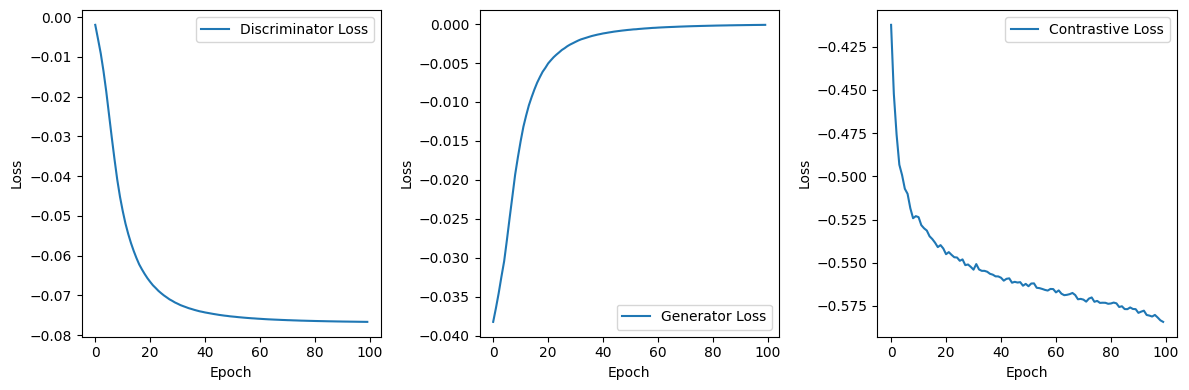

In [4]:
def plot_losses(d_losses, g_losses, cl_losses):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(g_losses, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(cl_losses, label='Contrastive Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# Main execution
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Read data
    smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean_test.txt", 
                           header=None, names=['SMILES'])
    num_epochs=100
    
    # Train models with error handling
#     try:
    graph_gan, encoder, d_losses, g_losses, cl_losses = train_gan_cl_improved(smiles_df, num_epochs)

    # Plot losses
    plot_losses(d_losses, g_losses, cl_losses)

    # Save models
    torch.save({
        'graph_gan_state_dict': graph_gan.state_dict(),
        'encoder_state_dict': encoder.state_dict()
    }, 'molecular_gan_cl_models_CA11.pt')
        
#     except Exception as e:
#         print(f"Training failed: {str(e)}")